## Import packages

In [16]:
import pandas as pd
import geojson as gsn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import spatial analysis packages
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import geoplot.crs as gcrs
import geoplot as gplt
import pyproj
from shapely.geometry import Polygon
import haversine as hs
import pickle
from datetime import date
from statsmodels.tsa.seasonal import seasonal_decompose


## Ground Measures Data

### Ground Measure metadata

Ground measure data provides us with the measure snow water equivalent (SWE) at SNOTEC and CDEC sites across western U.S.

In [2]:
gm_md = pd.read_csv("../data/ground_measures_metadata.csv")
gm_md = gpd.GeoDataFrame(gm_md, geometry=gpd.points_from_xy(gm_md.longitude, gm_md.latitude))
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California,POINT (-118.77301 37.06668)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
...,...,...,...,...,...,...,...
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington,POINT (-121.66667 48.85000)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


In [13]:
len(gm_md['name'].unique())

745

In [3]:
gm_md.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   station_id   764 non-null    object  
 1   name         764 non-null    object  
 2   elevation_m  764 non-null    float64 
 3   latitude     764 non-null    float64 
 4   longitude    764 non-null    float64 
 5   state        764 non-null    object  
 6   geometry     764 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 41.9+ KB


In [4]:
gm_md_states = gm_md[['station_id','state']]
gm_md_states

,station_id,state
0,CDEC:ADM,California
1,CDEC:AGP,California
2,CDEC:ALP,California
3,CDEC:BCB,California
4,CDEC:BCH,California
...,...,...
759,SNOTEL:994_WA_SNTL,Washington
760,SNOTEL:995_WA_SNTL,Washington
761,SNOTEL:996_WA_SNTL,Washington
762,SNOTEL:998_WA_SNTL,Washington


### Ground measure data

Below is the SWE values from ground stations for our training dataset. 

In [5]:
gm_train_feat = pd.read_csv("../data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [6]:
gm_test_feat = pd.read_csv("../data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [7]:
#Combine the 2 dataframe with the time series

gm_df = gm_train_feat.merge(gm_test_feat, how='inner', on='station_id')
gm_df

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [8]:
#Combine df on states 

gm_df = gm_df.merge(gm_md_states, how='inner', on='station_id')

gm_df

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29,state
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00,California
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25,California
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Idaho
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00,Washington
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Utah
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10,Washington


## Prep time series data

In [9]:
# This function changes df from wide to long format:
def melt_data(df,state):
    """
    Takes the ground measure dataset in wide form.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the median of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(df, id_vars=['station_id','state'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted_df= melted.groupby('time').aggregate({'value':'median'})
    melted_df.rename(columns = {'value':state}, inplace = True)
    return melted_df

In [10]:
#Sniff test
melt_data(gm_df,'Utah')

,Utah
time,
2013-01-01,6.50
2013-01-08,6.80
2013-01-15,7.50
2013-01-22,7.53
2013-01-29,8.50
...,...
2021-06-01,0.00
2021-06-08,0.00
2021-06-15,0.00



Now, let's make a time series dataframe with all the states in it.

In [11]:
#Make a list of the states
state_list = list(gm_df['state'].unique())

# instantiate melted_df as an empty dataframe
gm_melted = pd.DataFrame()

# run a for loop over every state in our list
for state in state_list:
#     state_df = gm_df[gm_df['state'] == state] # get all the observations from the states we need
    state_melt = melt_data(gm_df,state) #melt dataframe
    if len(gm_melted) == 0: # replaces the empty dataframe with city_melt for the first iteration
        gm_melted = state_melt 
    else:
        gm_melted=gm_melted.join(state_melt) # joins city_melt with the melted_df for every subsequent iteration

#Sniff test
gm_melted

,California,Oregon,Colorado,Montana,Washington,Utah,Wyoming,Idaho,New Mexico,Nevada,Arizona,South Dakota
time,,,,,,,,,,,,
2013-01-01,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50,6.50
2013-01-08,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80,6.80
2013-01-15,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50,7.50
2013-01-22,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53
2013-01-29,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-06-08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-06-15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [19]:
gm_melted.isna().sum()

California      0
Oregon          0
Colorado        0
Montana         0
Washington      0
Utah            0
Wyoming         0
Idaho           0
New Mexico      0
Nevada          0
Arizona         0
South Dakota    0
dtype: int64

In [18]:
gm_melted.index

DatetimeIndex(['2013-01-01', '2013-01-08', '2013-01-15', '2013-01-22',
               '2013-01-29', '2013-02-05', '2013-02-12', '2013-02-19',
               '2013-02-26', '2013-03-05',
               ...
               '2021-04-27', '2021-05-04', '2021-05-11', '2021-05-18',
               '2021-05-25', '2021-06-01', '2021-06-08', '2021-06-15',
               '2021-06-22', '2021-06-29'],
              dtype='datetime64[ns]', name='time', length=270, freq=None)

In [19]:
gm_melted['Washington']

time
2013-01-01    6.50
2013-01-08    6.80
2013-01-15    7.50
2013-01-22    7.53
2013-01-29    8.50
              ... 
2021-06-01    0.00
2021-06-08    0.00
2021-06-15    0.00
2021-06-22    0.00
2021-06-29    0.00
Name: Washington, Length: 270, dtype: float64

## Time Series EDA

In [33]:
gm_resampled = gm_melted.resample('M').median()

gm_resampled.interpolate(method='spline')

ValueError: You must specify the order of the spline or polynomial.

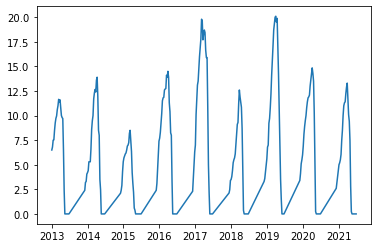

In [21]:
plt.plot(gm_melted['Washington'])

In [31]:
#Decomposing
decomposition = seasonal_decompose(gm_resampled['Washington'])

#Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(gm_melted['Washington'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

ValueError: This function does not handle missing values

## Model Building